# **Individual task 3** - C. Soneira:

### *Analysis of the gravitational wave event LIGO/GW150914: is dark matter made of primordial stellar-mass black holes?*

In [134]:
jupyter nbconvert 'Individual_Task_3.ipynb' --to slides

[NbConvertApp] Converting notebook Individual_Task_3.ipynb to slides
[NbConvertApp] Writing 1409119 bytes to Individual_Task_3.slides.html


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as sp
from scipy.signal import argrelextrema
from scipy import interpolate
import math

### **Q1**: See the information on GW150914 at https://www.gw-openscience.org/events/GW150914, and then build the data files:
- H1f.dat = filtered signal from the Hanford detector (H1)
- H1fmod.dat = numerical relativity model for the filtered signal from H1
- H1tmod.dat= numerical relativity model for the unfiltered signal from H1.

Show in the same figure the data in H1f.dat (sometimes signals are filtered to remove observational noise) and H1fmod.dat around the coalescence epoch, i.e. from 0.36 to 0.44 s. Is there agreement between observed and model signal?

In [2]:
X = pd.read_csv('H1f.dat', sep=" ",header=0)
Y = pd.read_csv('H1fmod.dat', sep=" ",header=0)
Z = pd.read_csv('H1tmod.dat', sep=" ",header=0)

# Observed filtered (of)
of_t=np.array(X["#"])
of_h=np.array(X["time"])

# Modelled filtered (mf)
mf_t=np.array(Y["#"])
mf_h=np.array(Y["time"])

# Modelled unfiltered (mu)
mu_t=np.array(Z["#"])
mu_h=np.array(Z["time"])

In [3]:
plt.style.use('seaborn-v0_8')
plt.ioff()

In [5]:
plt.ioff()
fig, ax = plt.subplots()
plt.plot(of_t, of_h,marker=",",linewidth=1.5,markersize=1,label='Observed filtered')
plt.plot(mf_t, mf_h,marker=",",linewidth=1.5,markersize=1,label='Modelled filtered')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Strain ($10^{-21}$)")
ax.set_title("Observed and modelled filtered signal in the colaescence")
ax.legend()
plt.rcParams["figure.figsize"] = (10,6)

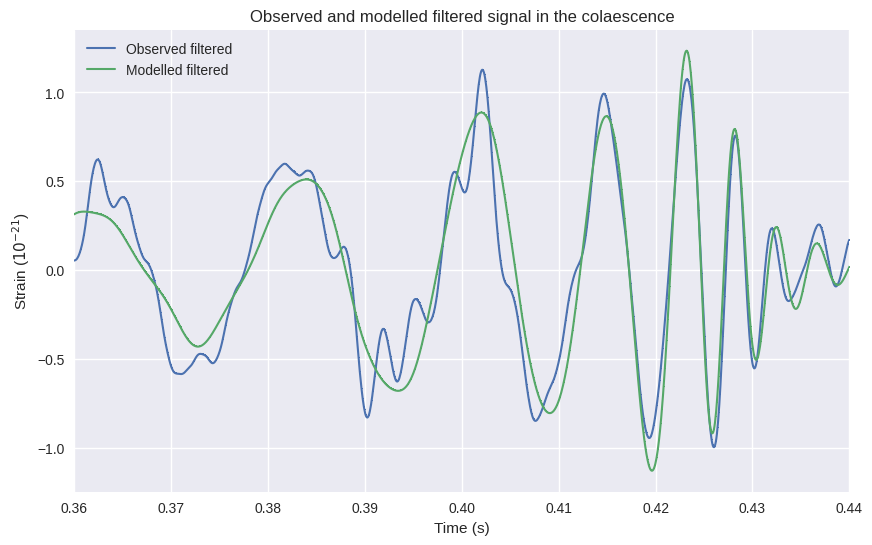

In [6]:
plt.xlim([0.36, 0.44])
plt.show()

## There is certain agreement, at least in the general amplitude and frequency behaviour.

### **Q2**: Focus on H1tmod.dat (model for the unfiltered signal) at times $t<0.4\ \mathrm{s}$, i.e. before the coalescence. The strain has the form

$$h(t) = A(t) \sin [ \omega (t) \cdot t],$$

where $\omega(t) = 2 \pi f(t)$ and $f(t)$ is the frequency. Thus, both amplitude and frequency depend on time. However, reasonably assuming that variability timescales of $A$ and $\omega$ are longer than the time interval between consecutive data ($Dt < 100\ \mathrm{ms}$), consider the approach

$$h(t) \approx a \sin ( \omega t),$$

where $a$ and $\omega$ are constants in a time interval $[t - Dt, t + Dt]$. Find the relationship between $f$, $h$ and $\frac{d^{2}h}{dt^{2}}$ in such interval, calculate the values of $f$ at maxima and minima of $h$, and show the corresponding behaviour of $f(t)$, i.e. time evolution of the frequency.

NOTE: Once a maximum/minimum of $h$ is found, it is possible to use the triplet of adjacent data centred at such extreme value to obtain

$$\frac{dh}{dt}\approx \frac{[h(t + Dt)- h(t - Dt)]}{2 Dt};\text{ }\frac{d^{2}h}{dt^{2}} \approx \frac{[h(t + Dt) – 2h(t) + h(t - Dt)]}{ Dt^{2}}$$

In [7]:
fig, ax = plt.subplots()
plt.plot(mu_t, mu_h,marker=",",linewidth=1.5,markersize=1,label='Modelled unfiltered')
plt.plot(mf_t, mf_h,marker=",",linewidth=1.5,markersize=1,label='Modelled filtered')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Strain ($10^{-21}$)")
plt.title("Unfiltered and filtered signal")
ax.legend()

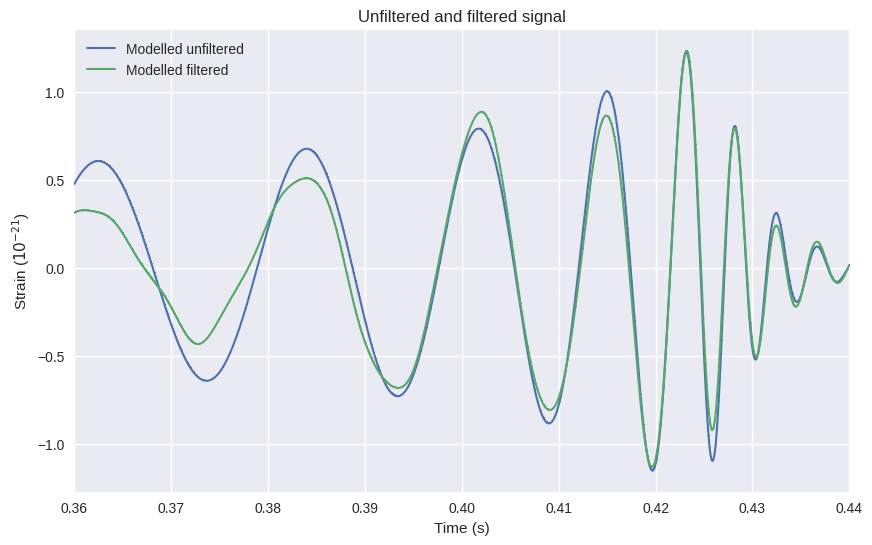

In [8]:
plt.xlim([0.36, 0.44])
plt.show()

And the relationship between $f$, $h$ and $\frac{d^{2}h}{dt^{2}}$, assuming $h(t) \approx a \sin ( 2\pi f \cdot t),$ is the following: $$\frac{dh}{dt}=a\cdot 2\pi f\cdot \cos(2\pi f \cdot t)\implies$$ $$\implies\frac{d^{2}h}{dt^{2}}=-a\cdot 4\pi^{2}\cdot f^{2} \sin(2\pi f\cdot t)=-4\pi^{2} f^{2}\cdot h\iff$$ $$\iff\frac{d^{2}h}{dt^{2}}=-4\pi^{2} f^{2}\cdot h$$

### We start the fitting process

In [9]:
# We calculate the index in which time grows Dt=100 ms:

for i in range(len(mu_t)):
    if mu_t[i]-mu_t[0] > 0.1:
        print(i)
        break

1639


### We select the indices of the relative extrema.

In [10]:
a=np.array(argrelextrema(mu_h, np.greater))
a=np.transpose(a)
b=np.array(argrelextrema(mu_h, np.less))
b=np.transpose(b)
c=np.concatenate((a,b))
c=np.transpose(c)
index=c[0]

### We perform a non linear fit in each extrema:

In [11]:
f=[]; nnnt=[]; newindex=[]

def func(x, a, f,t):
    return a*np.sin(2*math.pi*f*x+t)

for Dt in [50]:
    j=0
    for i in index:
        if mu_t[i] < 0.4:
            
            newindex=np.concatenate((newindex,[j]))
            
            mu_fit_t=mu_t[i-Dt:i+Dt]
            mu_fit_h=mu_h[i-Dt:i+Dt]
            param, error = sp.curve_fit(func, mu_fit_t,mu_fit_h,p0=[1,10,math.pi/4])

            plt.plot(mu_t,mu_h,linewidth=0.01)
            plt.plot(mu_fit_t,func(mu_fit_t,param[0],param[1],param[2]))
            plt.xlabel("Time (s)"); plt.ylabel("Strain ($10^{-21}$)")
            plt.title("Modelled fitted filtered signal")
            
            nnnt=np.concatenate((nnnt,[mu_t[i]]))
            f=np.concatenate((f,[param[1]]))
            j=j+1

In [12]:
# Derivatives of h in case they are necessary:
# h_firstder=(mu_fit_h[-1]-mu_fit_h[0])/2*(mu_t[i-Dt]-mu_t[i+Dt])
# h_secder=(mu_fit_h[-1]-2*mu_fit_h[int(Dt/2)]+mu_fit_h[0])/Dt**2

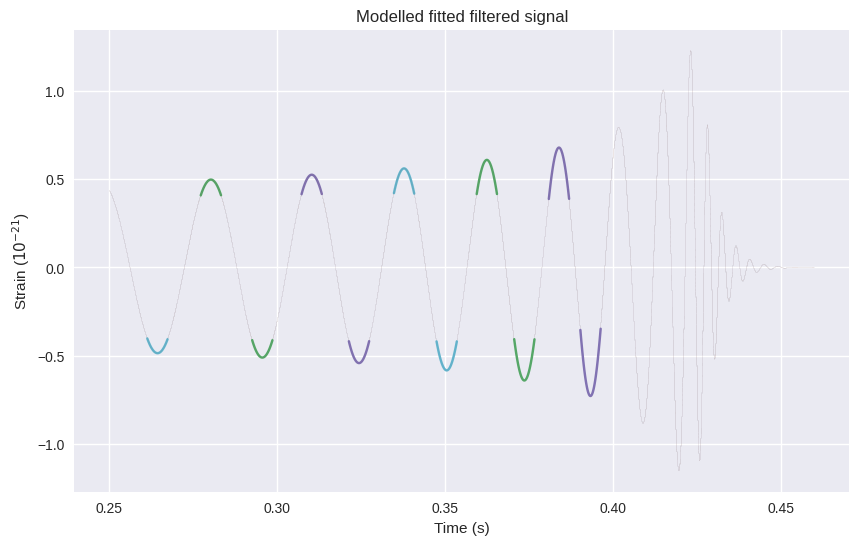

In [13]:
plt.show()

### We plot the frequency

In [14]:
h=mu_h[newindex.astype(int)]
t=nnnt
f=abs(f)

fig, ax = plt.subplots()
ax.plot(t,f,marker="o",linewidth=0,markersize=7)
ax.set_xlabel("Time (s)")
ax.set_ylabel("$f$ (Hz)")
ax.set_title("Frequency vs. time")

Text(0.5, 1.0, 'Frequency vs. time')

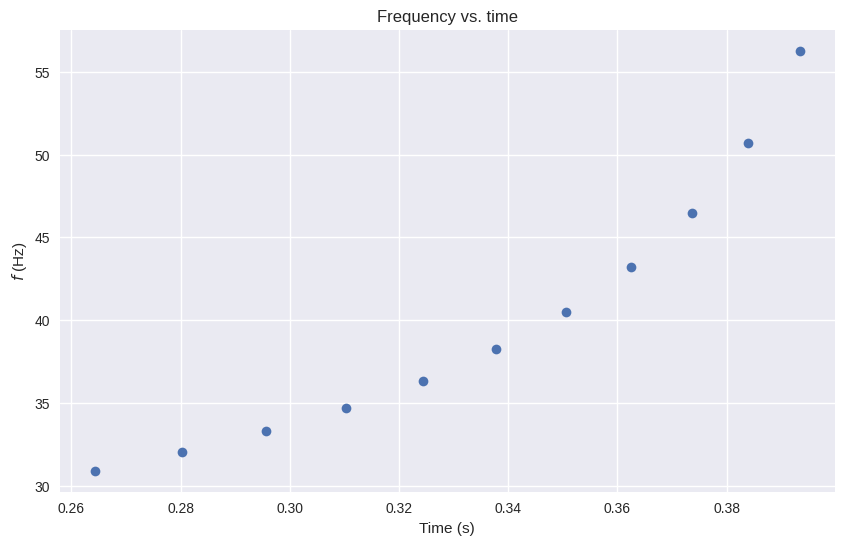

In [15]:
plt.show()

### Now we are going to fit the frequency with a function like $g(x)=a+b\cdot \exp(c\cdot x)$ **based only in numerical reasons, not physical ones.** Also we are doing a linear extrapolation.

### The extrapolated values at $t=0.2\ \mathrm{s}$ for the frequency are:

In [16]:
inter1 = interpolate.interp1d(t,f, kind='linear',fill_value='extrapolate')
linfreq=inter1(0.2)

print("Linear: ",f'{linfreq:.2f}',"Hz")

def ex(x, a, w,b):
    return a+w*np.exp(b*x)

param, error = sp.curve_fit(ex,t,f,p0=[2,2,2])

xx=np.linspace(0.18,0.4,50)
tt=ex(xx,param[0],param[1],param[2])
freqext=ex(0.2,param[0],param[1],param[2])

print("Non linear: ",f'{freqext:.2f}',"Hz")

Linear:  26.33 Hz
Non linear:  30.08 Hz


### And the plot is:

In [17]:
fig, ax = plt.subplots()
ax.plot(t,f,marker=".",linewidth=0,markersize=14)
ax.plot(xx,tt,':',linewidth=2,label="Exponential extrapolation")
ax.plot(xx,inter1(xx),'--',linewidth=1,markersize=3,label="Linear extrapolation")
ax.set_xlabel("Time (s)")
ax.set_ylabel("$f$ (Hz)")
ax.set_title("Frequency vs. time (fitting)")
ax.legend()

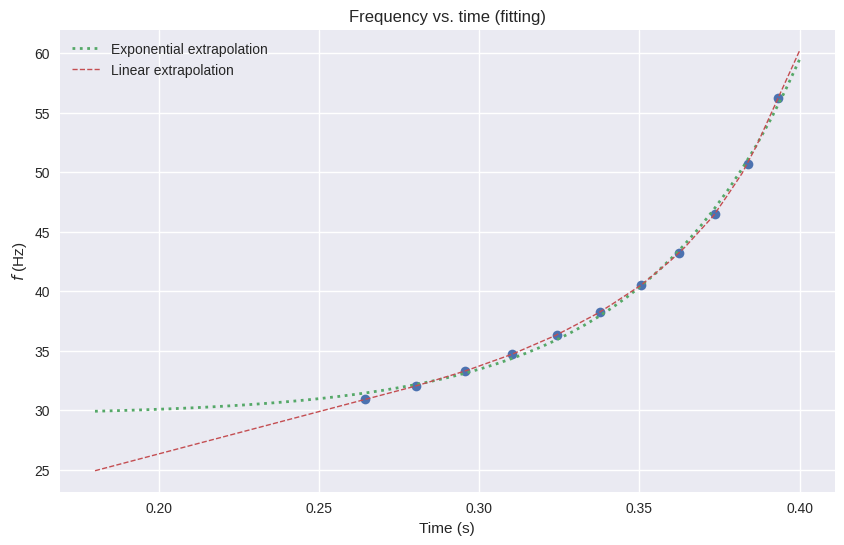

In [18]:
plt.show()

### **Q3**: Estimate $M_{c}$ of the binary system using the behaviour of $f(t)$ in Q2 and values of $\frac{dh}{dt}$ from triplets of adjacent data.
Show the $M_{c}$ estimates in solar masses, and **assume that our basic equation works better when time is smaller** (well separated objects). At epochs close to the coalescence (merger), important relativistic corrections are required. Therefore, perform a linear extrapolation at $t = 0.2\ \mathrm{s}$ (using the nine measurements), and compare the extrapolated chirp mass with the chirp mass detected by the LIGO collaboration. Are the two masses consistent to each other?

### Numeric frequency derivative: $\dot{f}$

In [22]:
def der(t,x):
    deriv = []
    for i in range(1,len(t)-1):
        deriv=np.concatenate((deriv,[(x[i+1]-x[i-1])/(2*(t[i+1]-t[i]))]))
    return deriv

t=np.sort(t)
f=np.sort(f)

fdott=der(t,f)

In [23]:
fig, ax = plt.subplots()
plt.plot(t[1:-1],fdott,marker='.',linewidth=0,markersize=12)
ax.set_xlabel("Time (s)")
ax.set_ylabel("$df/dt$ (Hz$\cdot s^{-1}$)")
ax.set_title("Frequency time derivative vs. time (fitting)")

Text(0.5, 1.0, 'Frequency time derivative vs. time (fitting)')

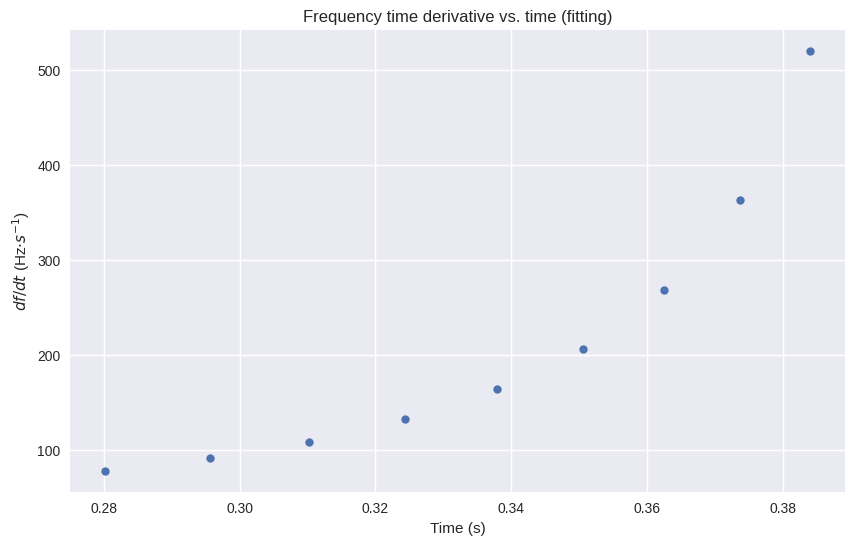

In [24]:
plt.show()

### We calculate the chirp mass in each point.

In [28]:
c=299792458
G=6.6743*10**(-11)
Solar=1.989*10**30

def Mc (f,fdot):
    mc=c**3*( (5/96)*math.pi**(-8/3)*f**(-11/3)*fdot)**(3/5 )/Solar*1/G
    return mc

nf=f[1:-1]

m=Mc(nf,fdott)

fig, ax = plt.subplots()
ax.plot(t[1:-1],m,marker="o",linewidth=0,markersize=7)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Mass ($M_{\odot}$)")
ax.set_title("Mass vs Time")

Text(0.5, 1.0, 'Mass vs Time')

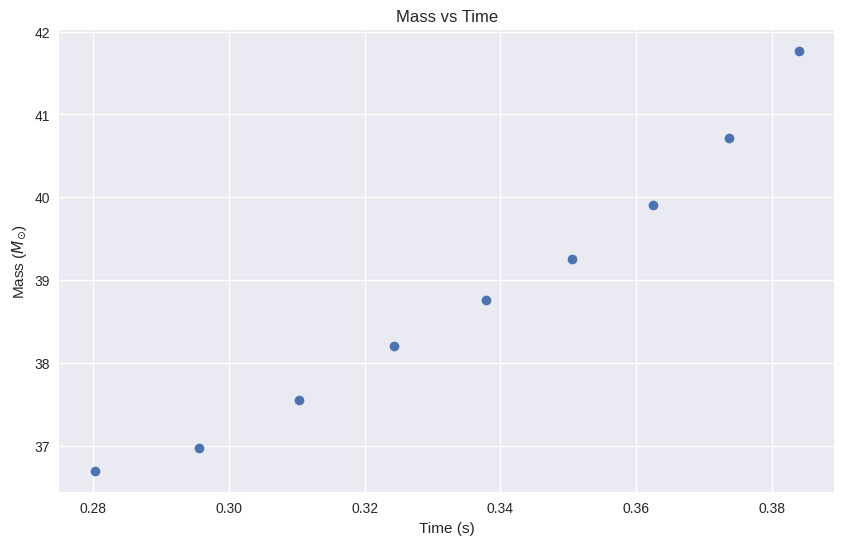

In [29]:
plt.show()

### The extrapolated values at $t=0.2\ \mathrm{s}$ for the chirp mass are:

In [30]:
inter = interpolate.interp1d(t[1:-1],m, kind='linear',fill_value='extrapolate')
interchirp=inter(0.2)

print("Linear: ",f'{interchirp:.2f}',"Solar masses")

chirp=ex(0.2,param[0],param[1],param[2])

print("Non linear: ",f'{chirp:.2f}',"Solar masses")

Linear:  35.28 Solar masses
Non linear:  30.08 Solar masses


### And the fit to obtain the values at $t=0.2\ \mathrm{s}$ is:

In [31]:
param, error = sp.curve_fit(ex,t[1:-1],m,p0=[20,10,10])

fig, ax = plt.subplots()
xx=np.linspace(0.18,0.4,50)
tt=ex(xx,param[0],param[1],param[2])
ax.plot(t[1:-1],m,marker=".",linewidth=0,markersize=14)
ax.plot(xx,tt,':',linewidth=2,label="Exponential extrapolation")
ax.plot(xx,inter(xx),'--',linewidth=1,markersize=3,label="Linear extrapolation")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Chirp mass ($M_{\odot}$)")
ax.set_title("Chirp mass vs Time (fitting)")
ax.legend()

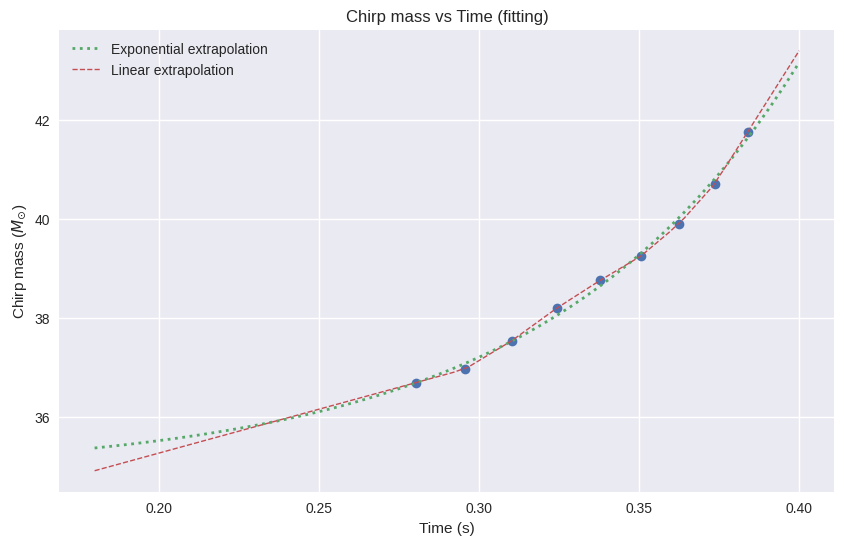

In [32]:
plt.show()

### **Q4**: Estimate the masses of the two objects of the binary system, assuming: (a) both members have similar mass (m1 $\approx$ m2), and (b) one is much more massive than other (m1 >> m2).
For the case (b), if we deal with stellar-type objects (m1 and m2 within the range 0.1-150 solar masses), discuss possible values of the pair (m1, m2). Taking into account results for cases (a) and (b), in what binary scenario have the gravitational waves been produced? NS+NS, NS+BH or BH+BH? Compare the results for both cases and detailed measurements of the LIGO collaboration (detected masses), and decide what case is more realistic

a) If $m_{1}\approx m_{2}$ then $$M_{C}\approx \frac{(m_{1}m_{2})^{3/5}}{(m_{1}+m_{2})^{1/5}}\approx \frac{m_{1}^{6/5}}{(2\cdot m_{1})^{1/5}}\approx \frac{1}{2^{1/5}}\cdot\frac{m_{1}^{6/5}}{m_{1}^{1/5}}=\frac{1}{2^{1/5}}\cdot m_{1}\iff$$

$$\iff m\approx 2^{1/5}\cdot M_{C}\approx 1.15\cdot M_{C}$$

In [33]:
MC=chirp/1.15
print("The mass of each object is ",f'{MC:.2f}',"solar masses, so it might be a system of black holes.")

The mass of each object is  26.15 solar masses, so it might be a system of black holes.


b) If $m_{1}\gt\gt m_{2}$ then $$M_{C}\approx \frac{(m_{1}\cdot m_{2})^{3/5}}{m_{1}^{1/5}}\approx m_{1}^{2/5}\cdot m_{2}^{3/5}$$

In [100]:
def hyp (m1):
    m2 = chirp**(5/3)/m1**(2/3)
    return m2

m1 = np.linspace(0.1,150,200)
m2 = hyp(m1)

fig, ax = plt.subplots()
ax.plot(m1,m2)
ax.set_xlabel("$m_{1}$ ($M_{\odot}$)"); ax.set_ylabel("$m_{2}$ ($M_{\odot}$)")
ax.set_title("Possible $m_{1}$ vs $m_{2}$ for the system")
plt.xlim([0.1,150]); plt.ylim([0.1,150])
plt.rcParams["figure.figsize"] = (6,6)

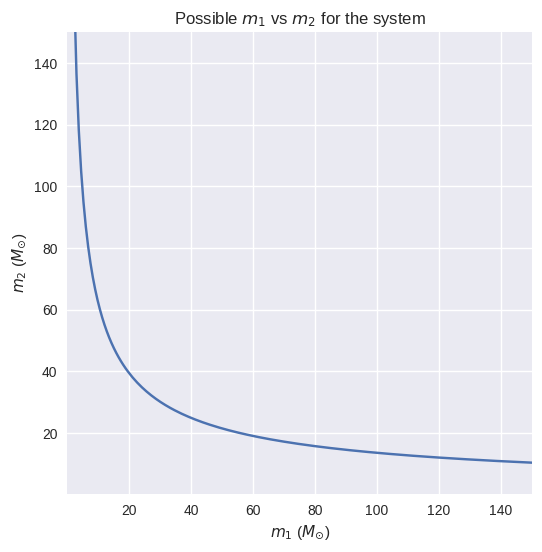

In [101]:
plt.show()

### In this case it is not reasonable that it is NS+NS or BH+NS but **BH+BH**: the hyperbola takes very high values of the pair but neutron stars are $\approx 1.4\ \mathrm{M_{\odot}}$

### **Q5**: Show the $D_{L}$ estimates at different (nine) epochs of the inspiral phase.
To obtain a reliable value of $D_{L}$, do a linear extrapolation at $t=0.2\ \mathrm{s}$ (using the nine measurements). Compare the extrapolated value and that obtained by the LIGO collaboration. Does the signal come from a region in the Milky Way?

### We start calculating nine values for $D_{L}$

In [85]:
Dl = lambda h,f,fd: (10*c*fd)/ (96*math.pi**2*abs(h)*10**(-21)*f**3) *3.2408*10**(-23)

nf=f[1:-1]

hn=h[1:-1]
Dlt=Dl(hn,nf,fdott)

fig, ax = plt.subplots()
ax.plot(t[1:-1],Dlt,marker="o",linewidth=0,markersize=5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Luminosity distance (Mpc)")
ax.set_title("Luminosity distance vs. time")
plt.rcParams["figure.figsize"] = (10,6)

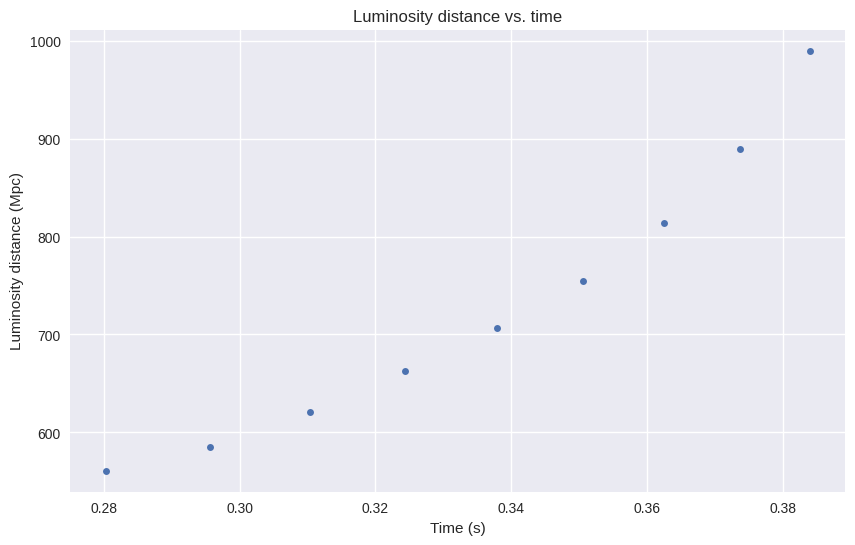

In [86]:
plt.show()

### The extrapolated values at $t=0.2\ \mathrm{s}$ for $D_{L}$ are:

In [87]:
interp2 = interpolate.interp1d(t[1:10],Dlt[0:9], kind='linear',fill_value='extrapolate')

print("Linear extrapolation: ",f'{interp2(0.2):.2f}',"Mpc")

param, error = sp.curve_fit(ex,t[1:-1],Dlt,p0=[20,10,10])
xx=np.linspace(0.18,0.4,50)
tt=ex(xx,param[0],param[1],param[2])
dll=ex(0.2,param[0],param[1],param[2])

print("Non linear extrap: ",f'{dll:.2f}', "Mpc")

Linear extrapolation:  431.40 Mpc
Non linear extrap:  510.03 Mpc


### And the fit to obtain the values at $t=0.2\ \mathrm{s}$ is:

In [88]:
fig, ax = plt.subplots()

ax.plot(t[1:-1],Dlt,marker="o",linewidth=0,markersize=7)
ax.plot(xx,tt,':',label="Exponential extrapolation")
ax.plot(xx,interp2(xx),'--',linewidth=1,markersize=3,label="Linear extrapolation")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Luminosity distance (Mpc)")
ax.set_title("Luminosity distance vs. time")
ax.legend()

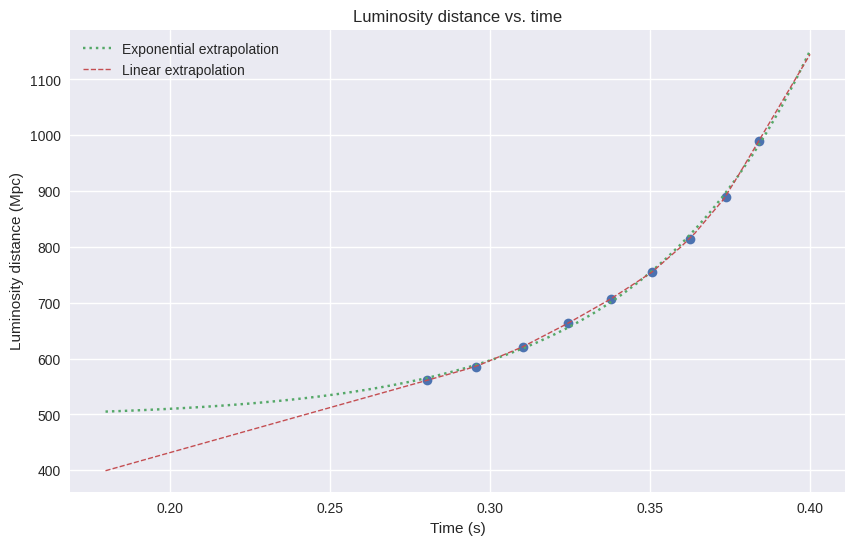

In [89]:
plt.show()

### So the system is not in the Milky Way, not even in its halo (which has a radius of $\approx$ 30 kpc).

### **In summary, we obtained**:
### - Chirp mass: $M_{C}\approx  35.6$ $M_{\odot}$
### - Mass: $m_{1}=26$ and $m_{2}$ $\approx 37$ $M_{\odot}$; total mass $\leq 63$ $M_{\odot}$.
### - Luminosity distance: $D_{L}\approx 432\ \mathrm{Mpc}$
### **LIGO collaboration obtained**:
### - Chirp mass: $M_{C}\approx 30.4$ $M_{\odot}$
### - Mass: $m_{1}=29$ and $m_{2}=36$ $M_{\odot}$; total mass is $\approx 63$ $M_{\odot}$.
### - Luminosity distance: $D_{L}\approx 410\ \mathrm{Mpc}$

### **Q6**: As a final test, go to the web simulator at http://data.cardiffgravity.org/waveform-fitter/ and read the information about it (“About”).
The observed signal (blue) corresponds to GW150914, and this signal can be compared with general relativitic simulations for a binary system formed by two objects of equal mass (yellow). Use your results (total mass in the RFS for the case (a) and DL) to check if the simulated waves reproduce or not the observations. Show a screenshot

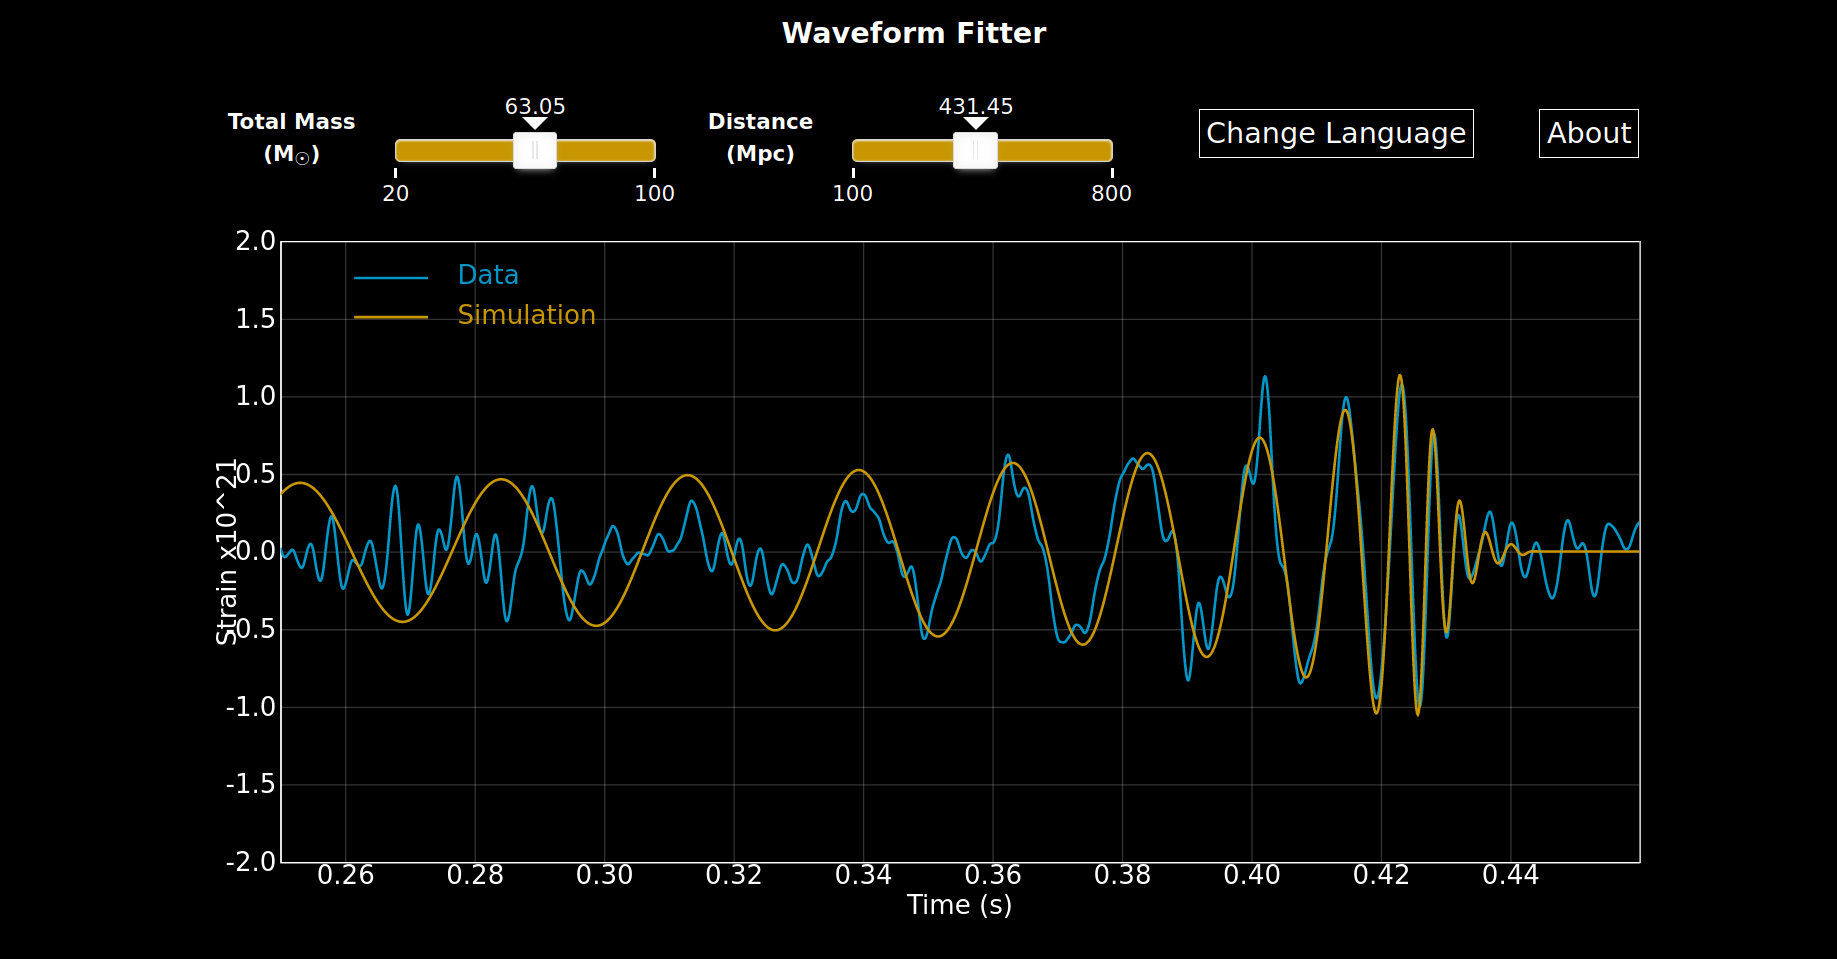

In [97]:
from IPython.display import Image
Image(filename='image.png',width = 1000)

### So... might dark matter be made of primordial stellar-mass BHs?
In *Primordial Black Holes as Dark Matter Candidates (Carr, 2022)* the authors postulate three mass windows for primordial black holes to be reasonable dark matter candidates:
- Sublunar: $10^{17}-10^{23}\ \mathrm{g}$
- **Mid range**: $10-10^{2}\ \mathrm{M_{\odot}}$, might be suggested by the LIGO collaboration.
- Stupendously Large Black Holes (SLAB): $\gt 10^{12}\ \mathrm{M_{\odot}}$

# Addendum

### If the vector frequency used for the calculations in slightly modified: `f[2:]` instead of `f[1:-1]`, then the results are:

In [91]:
Dl = lambda h,f,fd: (10*c*fd)/ (96*math.pi**2*abs(h)*10**(-21)*f**3) *3.2408*10**(-23)

nf=f[2:]

hn=h[1:-1]
Dlt=Dl(hn,nf,fdott)

fig, ax = plt.subplots()
ax.plot(t[1:-1],Dlt,marker="o",linewidth=0,markersize=5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Luminosity distance (Mpc)")
ax.set_title("Luminosity distance vs. time")
plt.rcParams["figure.figsize"] = (10,6)

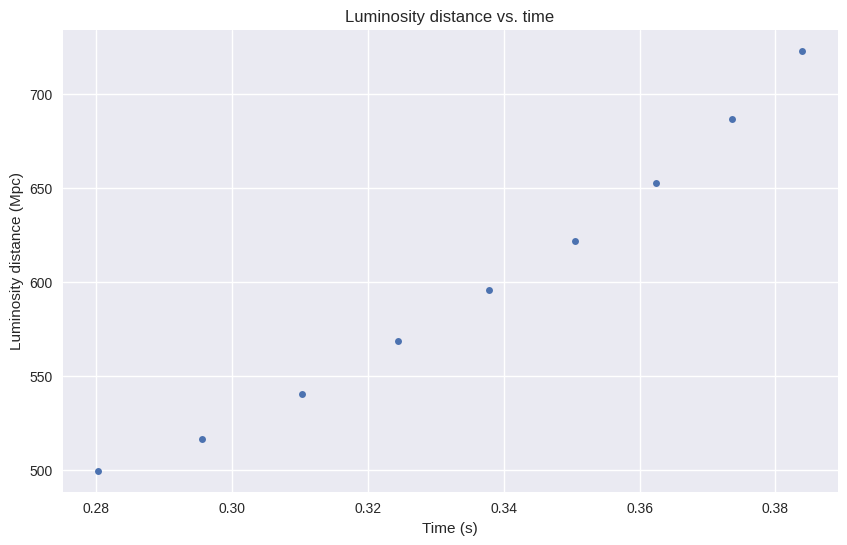

In [92]:
plt.show()

### And the extrapolated values are:

In [93]:
interp2 = interpolate.interp1d(t[1:10],Dlt[0:9], kind='linear',fill_value='extrapolate')

print("Linear extrapolation: ",f'{interp2(0.2):.2f}',"Mpc")

param, error = sp.curve_fit(ex,t[1:-1],Dlt,p0=[20,10,10])
xx=np.linspace(0.18,0.4,50)
tt=ex(xx,param[0],param[1],param[2])
dll=ex(0.2,param[0],param[1],param[2])

print("Non linear extrap: ",f'{dll:.2f}', "Mpc")

Linear extrapolation:  410.98 Mpc
Non linear extrap:  432.59 Mpc


### Which are closer to the LIGO result (410 Mpc) than the ones we obtained previously. We could try and plot these new case with the simulation software we used before.

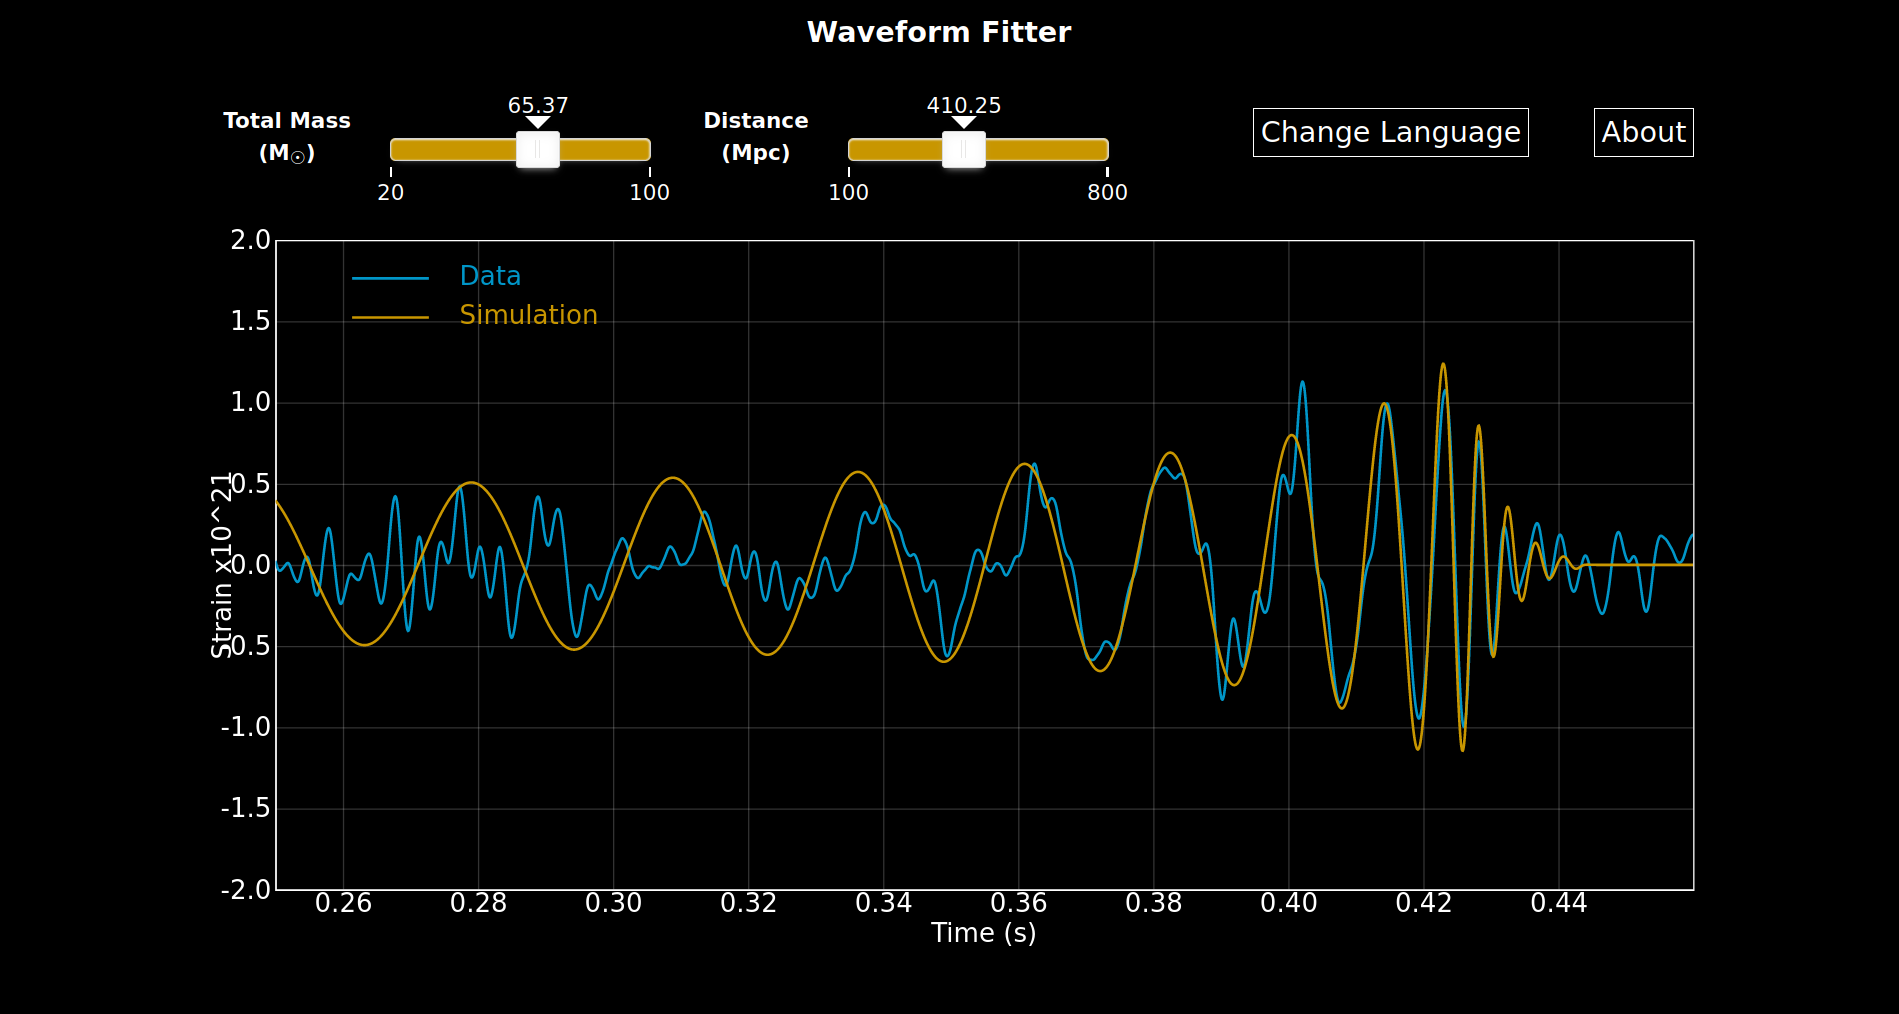

In [96]:
Image(filename='image2.png',width = 1000)

### We just saw that these value for the Luminosity Distance is closer to the LIGO result (410 Mpc) than the one we obtained previously. **In any case, I can not find a reason to justify that change in the frequency vector: this result requires calculating values in a point but using the frequency in the adjacent and not in that same point, something that we actually obtained with** `f[1:-1]`. Both cases, anyways, are good enough to conclude that the event had an origin quite far from the Milky Way.